# 1 - Decision Trees

## Classification and Regression Tree (CART)

A brief history on CART and Decision Trees. Proposed by Leo Breiman in the 80s (Breiman et al. 1984, Classification and Regression Tree), was the 2nd generation of Decision Tree Algorithms, succeeding algorithms such as AID (1963, Morgan & Sonquist), THAID (1972, Messenger & Mandell), CHAID (1980, Kass). The most recent developments (4th gen.) for DTAs happened in the early 21st century with GUIDE (Loh et al., 2015), BART (Chipman, 2010) and Random Forest (Breiman, 2001)

## Gini Index & Information Gain

Formula for Gini Index:
$$
G(t) = \sum_{i=1}^{c}p(i|t).(1-p(i|t)) = 1 - \sum_{i=1}^{c}p(i|t)^2
$$

Formula for Information Gain:
$$
IG = G(P) - \frac{N_L}{N}\times G(L) - \frac{N_R}{N}\times G(R)
$$
where $G(P)$ is the Gini Index of the parent node; $G(L)/G(R)$ are the Gini Index of the respective children nodes.

In [1]:
# Import our libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn import tree



In [2]:
# Read our data into a dataframe
df = pd.read_csv('datasets/titanic.csv')
df.shape

(891, 12)

These are what the column names represent:
* PassengerId - unique identifier
* Survived - 0 = No, 1 = Yes
* Pclass - 1 = 1st class, 2 = 2nd class, 3 = 3rd class
* Name 
* Sex
* Age
* SibSp - # of siblings / spouses aboard the Titanic
* Parch - # of parents / children aboard the Titanic	
* Ticket
* Fare
* Cabin
* Embarked - C = Cherbourg, Q = Queenstown, S = Southampton


In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Handling Missing Data 


### Types of Missing Data

1.   Missing Completly at Random (MCAR)
      - Missing Completely at Random (MCAR) is a type of missing data where the probability of a data point being missing is independent of all other variables in the data set, including the missing data itself. In other words, the missing data is completely random. \
      \
      An example of MCAR would be a survey where some respondents accidentally skipped a question. The reason for the missing data is unrelated to any of the other data in the survey, such as the respondent's age, gender, or political affiliation. \
      \
      Another example of MCAR would be a data set of customer purchases where some purchases are missing because the customer's credit card was declined. The reason for the missing data is unrelated to the customer's other purchases, such as the type of products they buy or how much they spend. \
      \
      MCAR is the most desirable type of missing data because it is the least likely to bias the results of statistical analyses.
2.   Missing at Random (MAR)
      - is a type of missing data where the probability of a data point being missing is independent of the missing data itself, but may depend on other observed variables in the data set. In other words, the missing data is not completely random, but it is possible to predict which data points are likely to be missing based on the other data that is available.
3.   Missing Not at Random (MNAR)
      - is a type of missing data where the probability of a data point being missing is related to the missing data itself, even after accounting for other observed variables in the data set. In other words, the missing data is not random, and it is not possible to fully predict which data points are likely to be missing based on the other data that is available.

How do we deal with missing data?
1. Deletion
2. Imputation (this can range from simply imputing mean, median or mode values into the dataset to creating machine learning algorithms that can estimate the value of the missing data.)

https://pandas.pydata.org/docs/user_guide/missing_data.html

In [4]:
# Preprocessing steps
df.fillna({'Age': df['Age'].mean(), 'Embarked': df['Embarked'].mode()[0]}, inplace=True)  # Processing steps
df['Sex'] = df['Sex'].factorize()[0] # label encoding
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the 'Embarked' column
encoded_embarked = encoder.fit_transform(df[['Embarked']])

# Create a DataFrame with the encoded columns
encoded_embarked_df = pd.DataFrame(
    encoded_embarked, 
    columns=encoder.get_feature_names_out(['Embarked']),
    index=df.index
)

# Concatenate the original DataFrame with the encoded columns
df = pd.concat([df, encoded_embarked_df], axis=1)

# Drop the original 'Embarked' column
df.drop('Embarked', axis=1, inplace=True)

df.head()




,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,1,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,0,35.0,0,0,8.0500,0.0,0.0,1.0


DecisionTreeClassifier: accuracy = 0.799


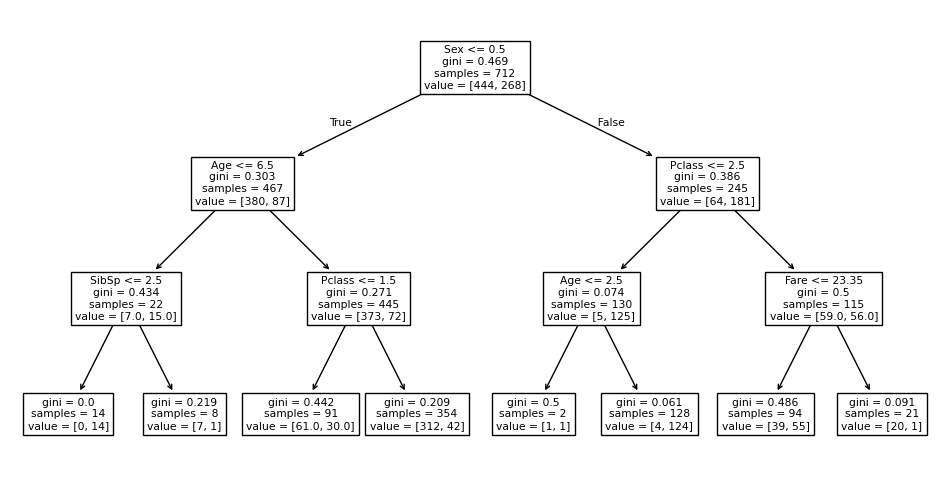

In [5]:
y = df['Survived']
x = df.drop('Survived', axis=1)
depth = 3 # depth of the tree - arbitrary depth is selected so that the tree doesn't go too far


# perform your train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

sk_model = DecisionTreeClassifier(max_depth=depth, 
                                  random_state=1)
sk_model.fit(x_train, y_train)
sk_pred = sk_model.predict(x_test)
acc = (y_test == sk_pred).mean()
print('DecisionTreeClassifier: accuracy = {:.3f}'.format(acc))

# plotting 
feature_names = x.columns.tolist()
plt.figure(figsize=(12, 6))
tree.plot_tree(sk_model,
               feature_names=feature_names)
plt.show()

## Feature Importance

Each feature in a dataset has differing levels of importance. Information Gain (IG) can be used to determine the importance of features in a dataset. 

$$
IG_{Sex} = 0.469 - (0.303\times467/712 - 0.386\times245/712) = 0.403 \\
$$

Since pclass is used twice and age is used twice, we take the weighted average of the IGs:

$$
IG_{pclass[1]} = 0.386 - (0.074\times130/245 - 0.5\times115/245) = 0.581 \\
IG_{pclass[2]} = 0.271 - (0.442\times91/445 - 0.209\times354/445) = 0.347 \\
IG_{pclass} = 0.581 \times 245/712 + 0.347 \times 445/712 = 0.417
$$

Same calculation for age:

$$
IG_{age[1]} = 0.303 - (0.434\times22/467 - 0.271\times445/467) = 0.541 \\
IG_{age[2]} = 0.074 - (0.5\times2/130 - 0.061\times128/130) = 0.126 \\
IG_{age} =  0.541 \times 467/712 +  0.126 \times 130/712 = 0.378
$$

Then we normalize by taking:

$$
IG_{Sex} = \frac{IG_{Sex}}{IG_{Sex}+IG_{pclass}+IG_{age}} \\

IG_{Sex} = 0.336 \\
IG_{pclass} = 0.348 \\
IG_{age} = 0.315 \\
$$

The value generated is the **importance** of each feature. Now let's find the optimal depth of the tree and the important features using sklearn.

In [6]:
# let's reuse the dataframe from previously
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,1,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,0,35.0,0,0,8.0500,0.0,0.0,1.0


Depth = 1, train_acc = 0.7753, eval_acc = 0.8433
Depth = 2, train_acc = 0.7897, eval_acc = 0.8134
Depth = 3, train_acc = 0.8138, eval_acc = 0.8806
Depth = 4, train_acc = 0.8347, eval_acc = 0.8582
Depth = 5, train_acc = 0.8507, eval_acc = 0.9179
Depth = 6, train_acc = 0.8780, eval_acc = 0.9030
Depth = 7, train_acc = 0.8957, eval_acc = 0.9104
Depth = 8, train_acc = 0.9053, eval_acc = 0.8806


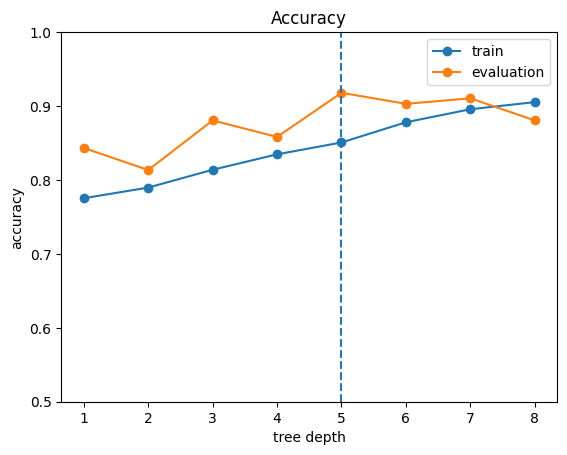

In [ ]:
# Separate the Titanic data into features and target class.
y = df['Survived']
x = df.drop('Survived', axis=1)

# Split the data into training, validation and test data. -- so we're splitting our data in 3 partitions instead of 2 like before
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

x_test, x_eval, y_test, y_eval = train_test_split(x_test, y_test, test_size = 0.5)

# Create decision tree models of various depths, 
# and measure the accuracy of validation data for each model.
train_acc = []
eval_acc = []
max_depth = 8
for d in range(1, max_depth+1):
    model = DecisionTreeClassifier(max_depth=d)
    model.fit(x_train, y_train)
    
    # Measure the accuracy of this model using the training data.
    y_pred = model.predict(x_train)
    train_acc.append((y_pred == y_train).mean())

    # Measure the accuracy of this model using the validation data.
    y_pred = model.predict(x_eval)
    eval_acc.append((y_pred == y_eval).mean())
    print('Depth = {}, train_acc = {:.4f}, eval_acc = {:.4f}'\
          .format(d, train_acc[-1], eval_acc[-1]))

# Find the optimal depth with the highest accuracy of validation data.
opt_depth = np.argmax(eval_acc) + 1

# Visualize accuracy changes as depth changes.
plt.plot(train_acc, marker='o', label='train')
plt.plot(eval_acc, marker='o', label='evaluation')
plt.legend()
plt.title('Accuracy')
plt.xlabel('tree depth')
plt.ylabel('accuracy')
plt.xticks(np.arange(max_depth), np.arange(1, max_depth+1))
plt.axvline(x=opt_depth-1, ls='--')
plt.ylim(0.5, 1.0)
plt.show()

Optimal depth = 5, test_acc = 0.7761


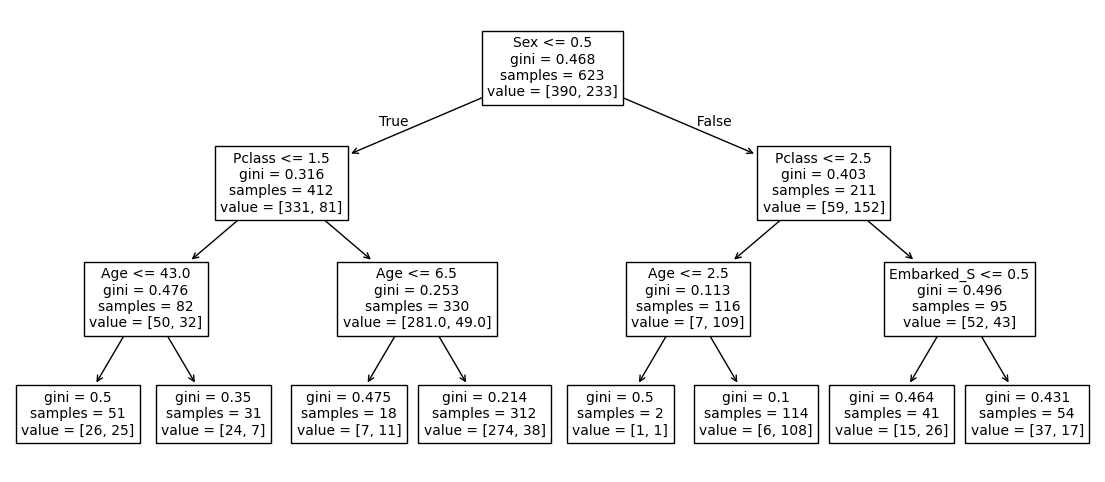

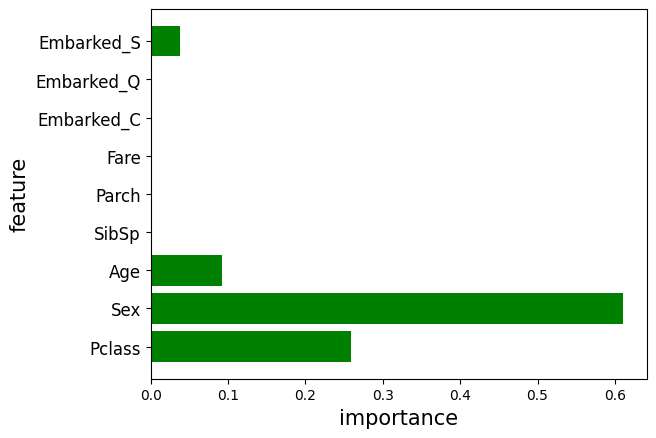

feature importance = [0.259 0.611 0.093 0.    0.    0.    0.    0.    0.038]


In [8]:
# I set max_step=3 as a constant value for tree visualization.
model = DecisionTreeClassifier(max_depth=3)
model.fit(x_train, y_train)

# Use test data to evaluate final performance.
y_pred = model.predict(x_test)
test_acc = (y_pred == y_test).mean()
print('Optimal depth = {}, test_acc = {:.4f}'.format(opt_depth, test_acc))
        
# Visualize the tree
# plt.figure(figsize=(20,10))
feat_names = x.columns.tolist()
plt.figure(figsize=(14,6))
tree.plot_tree(model, feature_names = feat_names, fontsize=10)
plt.show()

# Analyze the importance of features.
feature_importance = model.feature_importances_
n_feature = x_train.shape[1]
idx = np.arange(n_feature)

plt.barh(idx, feature_importance, align='center', color='green')
plt.yticks(idx, feat_names, size=12)
plt.xlabel('importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

print('feature importance = {}'.format(feature_importance.round(3)))

## Pruning

* As a tree gets deeper, error in training data decreases, however error in test data may increase (overfitting).
* To prevent this, pruning of branches in the complex tree is done to lower the complexity 
* In the previous code, we set the max_depth in advance based on repeated testing of different points of max_depth (technique is known as cross-validation) - this is a pre-pruning method to deal with overfitting
* Here we learn a post-pruning algorithm called Cost Complexity Pruning (CCP) algorithm 

### Cost Complexity Pruning

Algorithm works like this: 

1.) Build a tree as deep as possible

2.) Calculate a measure called "cost complexity" for each node. This measure balances two factors:

* The error rate if we keep the subtree below this node
* The complexity of the subtree (basically, how many nodes it has)

3.) Find the weakest link: the node where removing its subtree would lead to the smallest increase in error relative to the decrease in complexity $(\alpha)$.

4.) Snip off that subtree, replacing it with a leaf node.

5.) Repeat steps 3-4, creating a series of progressively simpler trees.

6.) Use cross-validation to pick the best pruned tree that balances accuracy and simplicity by creating a list of $\alpha$ candidates. 

$$ 
\text{Cost Complexity: } C(T) = R(T) + \alpha|T| \\
$$
where $R(T)$ is the misclassification rate of a tree T, $\alpha$ the regularization constant, and $|T|$ being the number of leaf nodes in the tree. The objective is to **minimise** $C(T)$.



In [9]:
# let's reuse the dataframe from previously
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0.0,0.0,1.0
1,1,1,1,38.0,1,0,71.2833,1.0,0.0,0.0
2,1,3,1,26.0,0,0,7.9250,0.0,0.0,1.0
3,1,1,1,35.0,1,0,53.1000,0.0,0.0,1.0
4,0,3,0,35.0,0,0,8.0500,0.0,0.0,1.0


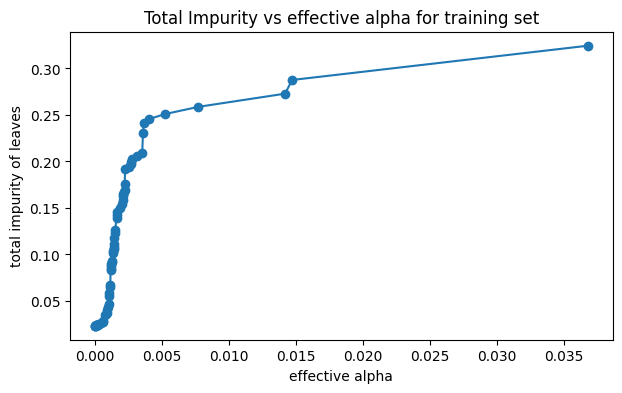

0) alpha = 0.0000 done.
1) alpha = 0.0000 done.
2) alpha = 0.0000 done.
3) alpha = 0.0001 done.
4) alpha = 0.0001 done.
5) alpha = 0.0001 done.
6) alpha = 0.0002 done.
7) alpha = 0.0002 done.
8) alpha = 0.0002 done.
9) alpha = 0.0003 done.
10) alpha = 0.0003 done.
11) alpha = 0.0005 done.
12) alpha = 0.0006 done.
13) alpha = 0.0006 done.
14) alpha = 0.0008 done.
15) alpha = 0.0008 done.
16) alpha = 0.0009 done.
17) alpha = 0.0009 done.
18) alpha = 0.0010 done.
19) alpha = 0.0010 done.
20) alpha = 0.0010 done.
21) alpha = 0.0011 done.
22) alpha = 0.0011 done.
23) alpha = 0.0012 done.
24) alpha = 0.0012 done.
25) alpha = 0.0012 done.
26) alpha = 0.0012 done.
27) alpha = 0.0012 done.
28) alpha = 0.0013 done.
29) alpha = 0.0013 done.
30) alpha = 0.0013 done.
31) alpha = 0.0014 done.
32) alpha = 0.0014 done.
33) alpha = 0.0014 done.
34) alpha = 0.0014 done.
35) alpha = 0.0015 done.
36) alpha = 0.0015 done.
37) alpha = 0.0015 done.
38) alpha = 0.0016 done.
39) alpha = 0.0017 done.
40) alpha 

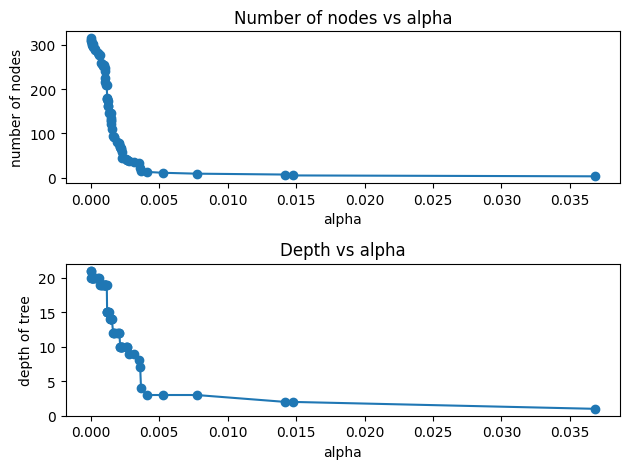

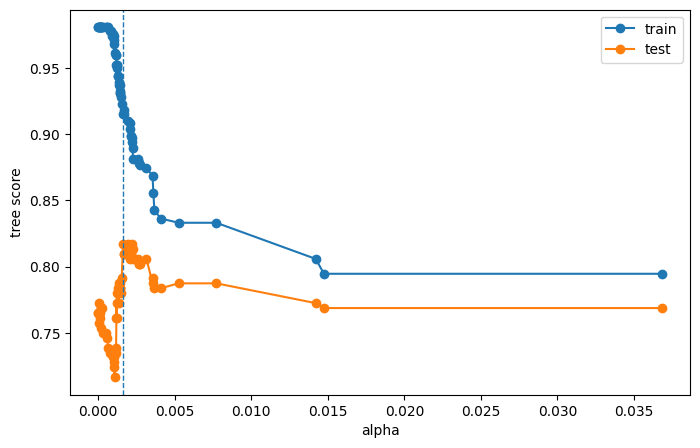

Accuracy of test data = 0.8172
Optimal alpha = 0.00162847


In [10]:
# Separate the Titanic data into features and target class.
y = df['Survived']
x = df.drop('Survived', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

# Apply Cost Complexity Pruning (CCP) and get the alpha-star list.
model = DecisionTreeClassifier()
path = model.cost_complexity_pruning_path(x_train, y_train)
ccp_alpha = path.ccp_alphas[:-1]  # exclude the last one.
impurity = path.impurities[:-1]

# Observe impurity changes for alpha changes.
# As alpha increases, the penalty for |T| increases, resulting in
# simple trees and increased impurity (misclassification error).
plt.figure(figsize=(7,4))
plt.plot(ccp_alpha, impurity, marker='o')
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")
plt.show()

# C(T) = R(T) + α|T|
# Create trees for each alpha in the alpha-list.
models = []
for i, alpha in enumerate(ccp_alpha):
    model = DecisionTreeClassifier(ccp_alpha=alpha)
    model.fit(x_train, y_train)
    models.append(model)
    print('%d) alpha = %.4f done.' % (i, alpha))

# You can see that as alpha increases, 
# the number and depth of nodes decrease.
node_counts = [model.tree_.node_count for model in models]
depth = [model.tree_.max_depth for model in models]

fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alpha, node_counts, marker="o")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alpha, depth, marker="o")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

# Among the candidate trees, find the one with the lowest 
# misclassification rate on the test data. It's the same to find 
# the tree with the highest score.
# Calculate the score of the tree (model) with alpha applied.
train_score = [model.score(x_train, y_train) for model in models]
test_score = [model.score(x_test, y_test) for model in models]

# Find the alpha that creates the tree with the highest score on 
# the test data. This is the optimal alpha, and the tree is optimal.
i_max = np.argmax(test_score)
opt_alpha = ccp_alpha[i_max]
opt_model = models[i_max]

# Observe the change in score for the change in alpha.
plt.figure(figsize=(8,5))
plt.plot(ccp_alpha, train_score, marker='o', label='train')
plt.plot(ccp_alpha, test_score, marker='o', label='test')
plt.axvline(x=opt_alpha, ls='--', lw=1.0)
plt.legend()
plt.xlabel('alpha')
plt.ylabel('tree score')
plt.show()

# Evaluate the performance of the final tree.
print('Accuracy of test data = %.4f' % opt_model.score(x_test, y_test))
print('Optimal alpha = %.8f' % opt_alpha)


## Multiclass Classification

In [11]:
# Load in our dataset
iris = load_iris(as_frame=True)
x = iris.data 
y = iris.target

# Generate training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y)

Accuracy of Model = 0.921


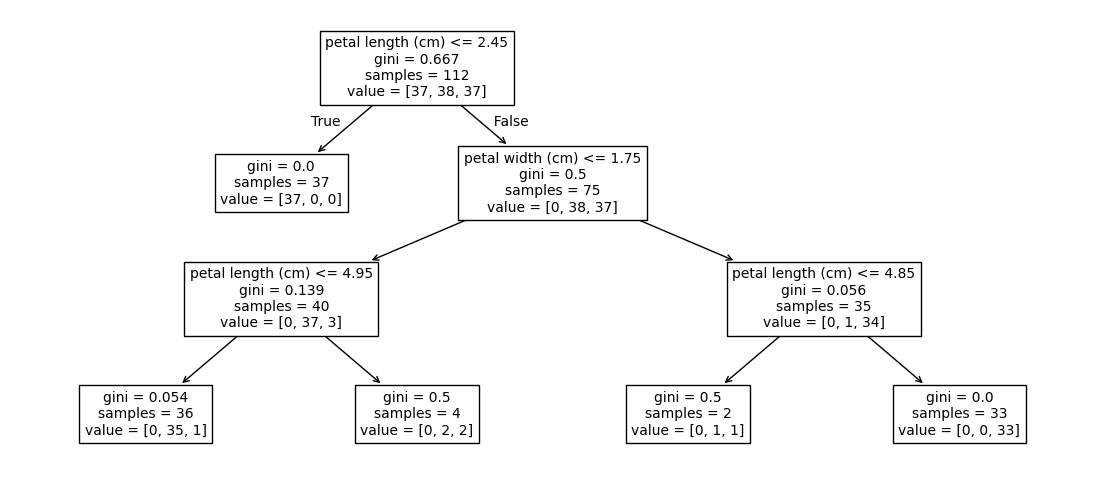

In [12]:
# Initialize the DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=3)
model.fit(x_train, y_train)

# Estimate the class of validation date.
y_pred = model.predict(x_test)

# Measure the accuracy for validation data
accuracy = (y_test == y_pred).mean()
print('Accuracy of Model = {:.3f}'.format(accuracy))

# Visualize the tree
# plt.figure(figsize=(20,10))
feat_names = x.columns.tolist()
plt.figure(figsize=(14,6))
tree.plot_tree(model, feature_names = feat_names, fontsize=10)
plt.show()

## Regression using Decision Trees

In [13]:
# Plot the training data and draw the estimated curve.
def plot_prediction(x, y, x_test, y_pred, title):
    plt.figure(figsize=(6,4))
    plt.scatter(x, y, c='blue', s=20, alpha=0.5, label='train data')
    plt.plot(x_test, y_pred, c='red', lw=2.0, label='prediction')
    plt.xlim(0, 1)
    plt.ylim(0, 7)
    plt.legend()
    plt.title(title)
    plt.show()

# Generate nonlinear data for regression testing.
def noisy_sine_data(n, s):
   rtn_x, rtn_y = [], []
   for i in range(n):
       x= np.random.random()
       y= 2.0*np.sin(2.0*np.pi*x)+np.random.normal(0.0, s) + 3.0
       rtn_x.append(x)
       rtn_y.append(y)
   return np.array(rtn_x).reshape(-1,1), np.array(rtn_y)

# Create training and test data
x_train, y_train = noisy_sine_data(n=500, s=0.5)
x_test = np.linspace(0, 1, 50).reshape(-1, 1)  


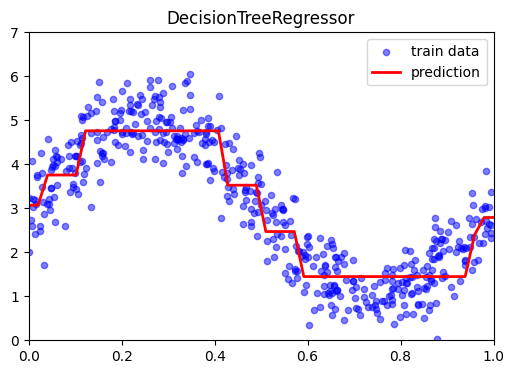

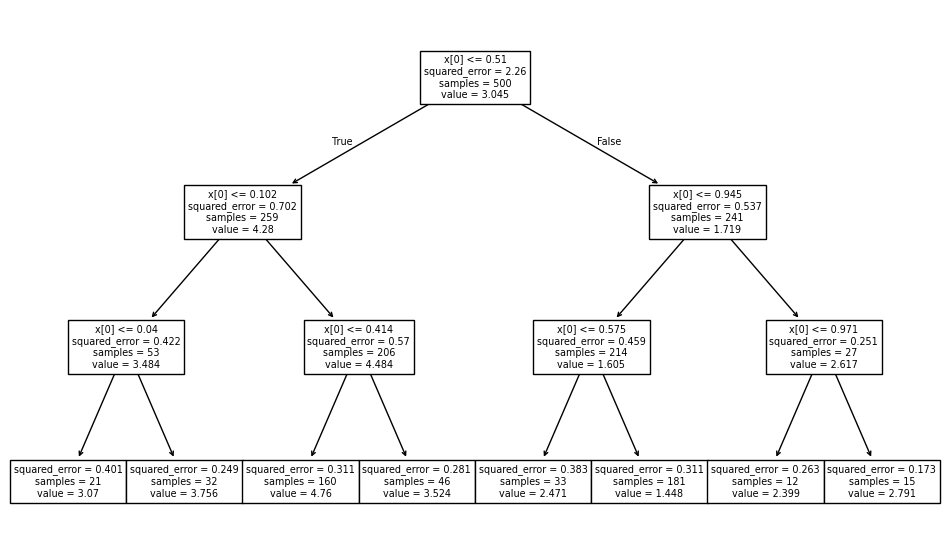

In [14]:
depth = 3

sk_model = DecisionTreeRegressor(max_depth = depth)
sk_model.fit(x_train, y_train)
sk_pred = sk_model.predict(x_test)

# Plot the training data and draw the estimated curve.
plot_prediction(x_train, y_train, x_test, sk_pred, 'DecisionTreeRegressor')

plt.figure(figsize=(12,7))
tree.plot_tree(sk_model)
plt.show()


Some takeaways :

* The shallower the tree, the more likely it is to be underfitting, and the deeper the tree the more likely it is to be overfitting. 
* As with classification pruning is necessary to prevent overfitting. CCP can be applied to the regression problem as well; instead of misclassification rate $R(T)$ we use MSE/SSR for regression.
* Can also be applied for multiple features (multiple regression) 

# 2 - Random Forest

## Brief background

The first such algorithm was created in 1995 by Tin Kam Ho, while leading the Statistics and Learning Research Department at Bell Laboratories. Her work was then extended by Leo Breiman and Adele Cutler in 2001.

more info here: https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm

## Bootstrap Aggregation (Bagging)

Bootstrap aggregation, or "bagging," involves repeatedly sampling data with replacement to create multiple datasets, training a decision tree on each. In a Random Forest, each tree is grown using these bootstrapped samples, and only a random subset of features is considered at each split, resulting in diverse trees; the model then combines predictions from all trees, often by majority voting for classification, to improve accuracy and reduce variance.

## Subsampling

Data subsampling is a technique where multiple decision trees are trained on different subsets of rows and columns from the dataset without replacement. In Random Forests, each tree is built using a unique subset of data rows (row subsampling) and a random subset of features (column subsampling) at each split.

more info here: https://youtu.be/sQ870aTKqiM?si=rRB0fqNIzyfih2De



## Out-of-Bag (OOB) Score

The out-of-bag (OOB) score is an evaluation method used in Random Forests, where each tree is tested on the data points not included in its bootstrap sample (about one-third of the data). The OOB score is calculated by aggregating the predictions of these left-out points across all trees, providing an unbiased estimate of the model’s accuracy without needing a separate validation set.

## Coming back to the Titanic Dataset

Let us do some feature engineering to extract more features from a particular dataset. We do not have any idea currently if these features are statistically significant, but these are based on our discretion to what we believe will contain information that might not be evaluated in our current set of features.

In [15]:
# load the titanic dataset into a dataframe
df = pd.read_csv('datasets/titanic.csv')

Now we extract the title of each passenger from the `Name` column. We do this by applying a function that looks through every element and splitting the element by its punctuation and then isolating the title. It also removes any leading or trailing whitespaces from the title. A lambda function is a small anonymous function that can take any number of arguments but only return one expression. We call it using the 
.apply() method.

for more info on lambda functions: https://realpython.com/python-lambda/

In [16]:
# we create a new column called 'Title' that contains the title of the passengers
df['Title'] = df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [17]:
df['Title'].value_counts()

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

In [18]:
# Define the mapping dictionary
standardized_titles = {
    'Mr': 0, 'Miss': 0, 'Mrs': 0, 'Ms': 0,                              # Label 0 - Common Titles
    'Mlle': 1, 'Mme': 1,                                                # Label 1 - Young or Unmarried Ladies
    'Dr': 2, 'Rev': 2, 'Master': 2,                                     # Label 2 - Professional Titles
    'Capt': 3, 'Major': 3, 'Col': 3,                                    # Label 3 - Military/Official Titles
    'Sir': 4, 'Lady': 4, 'the Countess': 4, 'Don': 4, 'Jonkheer': 4     # Label 4 - Nobility Titles
}

# Map the normalized titles to the current titles in the 'Title' column
df['Title'] = df['Title'].map(standardized_titles)

# View value counts for the normalized titles
print(df['Title'].value_counts())

Title
0    825
2     53
4      5
3      5
1      3
Name: count, dtype: int64


Now let's create another new feature, `Family_Size`. We can do this by adding the `Parch` and `Sibsp` features together. 

In [19]:
df['Family_size'] = df['Parch'] + df['SibSp'] + 1

Let's drop the `PassengerID`, `Name`, `Ticket` and `Cabin` columns for now. Also we can see `Embarked` has 2 missing values so i'm using my discretion to add `N` to them. I'm also encoding `Sex` and `Embarked` features. 

In [20]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df['Embarked'] = df['Embarked'].fillna('N')  
df['Sex'] = df['Sex'].factorize()[0]                
df['Embarked'] = df['Embarked'].factorize()[0]  
df.info()    


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Sex          891 non-null    int64  
 3   Age          714 non-null    float64
 4   SibSp        891 non-null    int64  
 5   Parch        891 non-null    int64  
 6   Fare         891 non-null    float64
 7   Embarked     891 non-null    int64  
 8   Title        891 non-null    int64  
 9   Family_size  891 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 69.7 KB


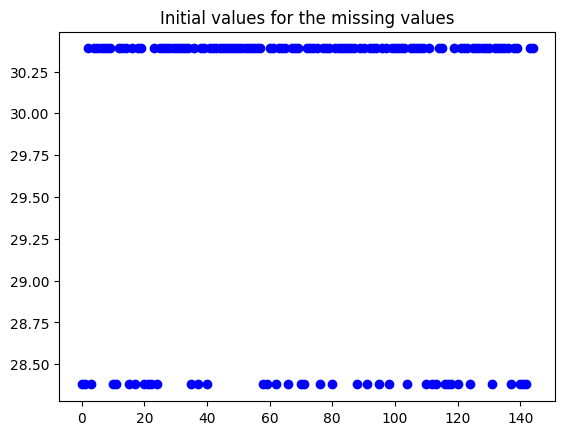

Before:
 [[ 3.    0.   34.5  ...  1.    0.    1.  ]
 [ 1.    1.   60.   ...  1.    0.    2.  ]
 [ 3.    1.   28.38 ...  2.    0.    1.  ]
 ...
 [ 3.    0.    0.42 ...  1.    2.    2.  ]
 [ 3.    0.   20.   ...  0.    0.    1.  ]
 [ 1.    0.   48.   ...  0.    0.    2.  ]]
y0_mean = 30.39, y1_mean = 28.38

After:
 [[ 3.    0.   34.5  ...  1.    0.    1.  ]
 [ 1.    1.   60.   ...  1.    0.    2.  ]
 [ 3.    1.   21.56 ...  2.    0.    1.  ]
 ...
 [ 3.    0.    0.42 ...  1.    2.    2.  ]
 [ 3.    0.   20.   ...  0.    0.    1.  ]
 [ 1.    0.   48.   ...  0.    0.    2.  ]]


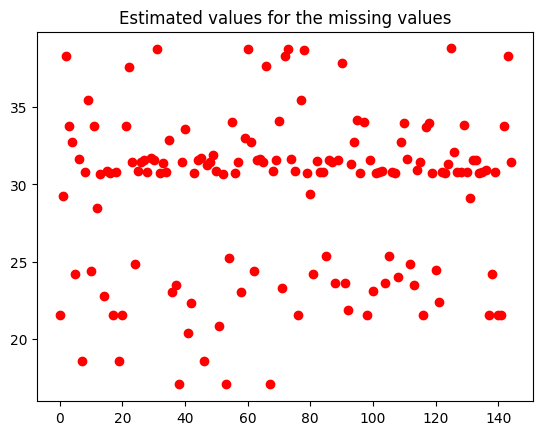


Results:
Accuracy = 0.8268
Final OOB error rate = 0.1601


In [22]:
# create training and test data
y = np.array(df['Survived'])
x = np.array(df.drop('Survived', axis=1))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Initially, missing values ​​in 'Age' are replaced with the average value.
AGE = 2  # column number of 'Age' feature

# the position of missing values. It is for later use.
i_train = np.where(np.isnan(x_train[:, AGE]))[0]  # training data
i_test = np.where(np.isnan(x_test[:, AGE]))[0]    # test data

# indices where y_train=0 and y_train=1
i_y0 = np.where(y_train == 0)[0]
i_y1 = np.where(y_train == 1)[0]

# the mean value of 'Age' where y_train=0, and the same where y_train=1.
y0_mean = np.nanmean(x_train[i_y0, AGE]) # where y_train=0
y1_mean = np.nanmean(x_train[i_y1, AGE]) # where y_train=1

# replace nan in 'Age' where y_train = 0 to y0_mean
x_train[i_y0, AGE] = np.nan_to_num(x_train[i_y0, AGE], nan=y0_mean)

# replace nan in 'Age' where y_train = 1 to y1_mean
x_train[i_y1, AGE] = np.nan_to_num(x_train[i_y1, AGE], nan=y1_mean)

# print('Before:\n', x_train.round(2))
# print('y0_mean = {:.2f}, y1_mean = {:.2f}'.format(y0_mean, y1_mean))
plt.plot(x_train[i_train, AGE], 'bo')
plt.title('Initial values for the missing values')
plt.show()

print('Before:\n', x_train.round(2))
print('y0_mean = {:.2f}, y1_mean = {:.2f}'.format(y0_mean, y1_mean))


# Create Proximity matrix
# normalize = 0: pm / n_tree
# normalize ≠ 0: Normalize columns to sum to 1
def proximity_matrix(model, x, normalize=0):
    n_tree = len(model.estimators_)
    
    # Apply trees in the forest to X, return leaf indices.
    leaf = model.apply(x)  # shape = (x.shape[0], n_tree)
    
    pm = np.zeros(shape=(x.shape[0], x.shape[0]))
    for i in range(n_tree):
        t = leaf[:, i]
        pm += np.equal.outer(t, t) * 1.

    np.fill_diagonal(pm, 0)    
    if normalize == 0:
        return pm / n_tree
    else:
        return pm / pm.sum(axis=0, keepdims=True)

n_estimators = 50
n_depth = 5

# Missing value imputation using the proximity matrix
for i in range(5):   # 5 iterations
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=n_depth,
                                   oob_score=True)
    model.fit(x_train, y_train)
    
    # Create proximity matrix
    pm = proximity_matrix(model, x_train, normalize=1)
    
    # estimate the missing values of 'Age' using the proximity matrix
    x_age = x_train[:, AGE].copy()
    u_age = np.dot(x_age, pm)       # updated 'Age'
    x_train[i_train, AGE] = u_age[i_train]

print('\nAfter:\n', x_train.round(2))
plt.plot(x_train[i_train, AGE], 'ro')
plt.title('Estimated values for the missing values')
plt.show()

# Train a new model after imputing missing values of training data
model = RandomForestClassifier(n_estimators=n_estimators,
                               max_depth=n_depth,
                               oob_score=True)
model.fit(x_train, y_train)

# Predict the test data. There are also missing values ​​in 'Age' in the test data.
#
# [2] Proximities
# When a test set is present, the proximities of each case in the test set 
# with each case in the training set can also be computed.

# Initially, there is no target value y in the test data, so the missing values ​​
# are replaced with the mean value of the training data.
x_test[i_test, AGE] = x_train[:, AGE].mean()

x_data = np.vstack([x_train, x_test]) # combine training and test data
pm = proximity_matrix(model, x_data, normalize=1)
x_age = x_data[:, AGE].copy()         # 'Age' feature data
u_age = np.dot(x_age, pm)             # updated 'Age' feature

u_age = u_age[-x_test.shape[0]:]      # 'Age' of test data
u_test = x_data[-x_test.shape[0]:]    # test data
u_test[i_test, AGE] = u_age[i_test]   # update the missing values in test data

# predict
y_pred = model.predict(u_test)

print('\nResults:')
print('Accuracy = {:.4f}'.format((y_pred == y_test).mean()))
print('Final OOB error rate = {:.4f}'.format(1 - model.oob_score_))